In [45]:

import glob
import os
import json

import yaml
from wandb.proto import wandb_internal_pb2
from wandb.sdk.internal import datastore

params_keys = ["r", "lr", "alpha"]
wandb_dir = "/mnt/baichuan2-lora/wandb"
project = 'baichuan2-lora_multiturn'

summary_dict = []
params = []
for directory in glob.glob(f"{wandb_dir}/offline*/"):
    
    wandb_metadata_path = directory + "files/wandb-metadata.json"
    if not os.path.exists(wandb_metadata_path):
        continue
    wandb_metadata = json.load(open(wandb_metadata_path,'r'))
    metadata_project = wandb_metadata['args'][0].split("=")[1]
    if metadata_project != project:
        continue
    
    config_path = directory + "files/config.yaml"
    if not os.path.exists(config_path):
        continue
    with open(config_path, "r", encoding="utf8") as f:
        config = yaml.safe_load(f)

    param = {p: config[p]["value"] for p in params_keys}
    params.append(param)
    start_time = float(config["_wandb"]["value"]["start_time"])

    db_file = glob.glob(directory + "*.wandb")[0]
    ds = datastore.DataStore()
    ds.open_for_scan(db_file)

    while True:
        if ds.in_last_block():
            break
        data = ds.scan_data()
        pb = wandb_internal_pb2.Record()
        pb.ParseFromString(data)
        record_type = pb.WhichOneof("record_type")

        if record_type == "history":
            tracked_value_0 = pb.history.item[0].value_json
            loss = [item.value_json for item in pb.history.item if item.key == "loss"][
                0
            ]
            ts = [
                item.value_json for item in pb.history.item if item.key == "_timestamp"
            ][0]

            summary = param.copy()
            summary['scale'] = summary['alpha'] / summary['r']
            summary.update({"loss": float(loss), "ts": float(ts) - start_time})
            summary_dict.append(summary)

print(len(params))
dataset = pd.DataFrame.from_dict(summary_dict)
print(dataset)


30
       r     lr  alpha  scale      loss            ts
0     16  0.002     16    1.0  3.171875     71.260937
1     16  0.002     16    1.0  3.203125    139.041727
2     16  0.002     16    1.0  2.953125    206.890023
3     16  0.002     16    1.0  2.734375    274.725864
4     16  0.002     16    1.0  2.484375    342.604194
...   ..    ...    ...    ...       ...           ...
5995  64  0.002     64    1.0  2.125000  13298.266947
5996  64  0.002     64    1.0  2.062500  13366.108129
5997  64  0.002     64    1.0  2.109375  13433.919594
5998  64  0.002     64    1.0  2.093750  13570.066960
5999  64  0.002     64    1.0  2.140625  13570.068979

[6000 rows x 6 columns]


[['lr', 'alpha', 'r'], ['alpha', 'r', 'lr'], ['r', 'lr', 'alpha']]


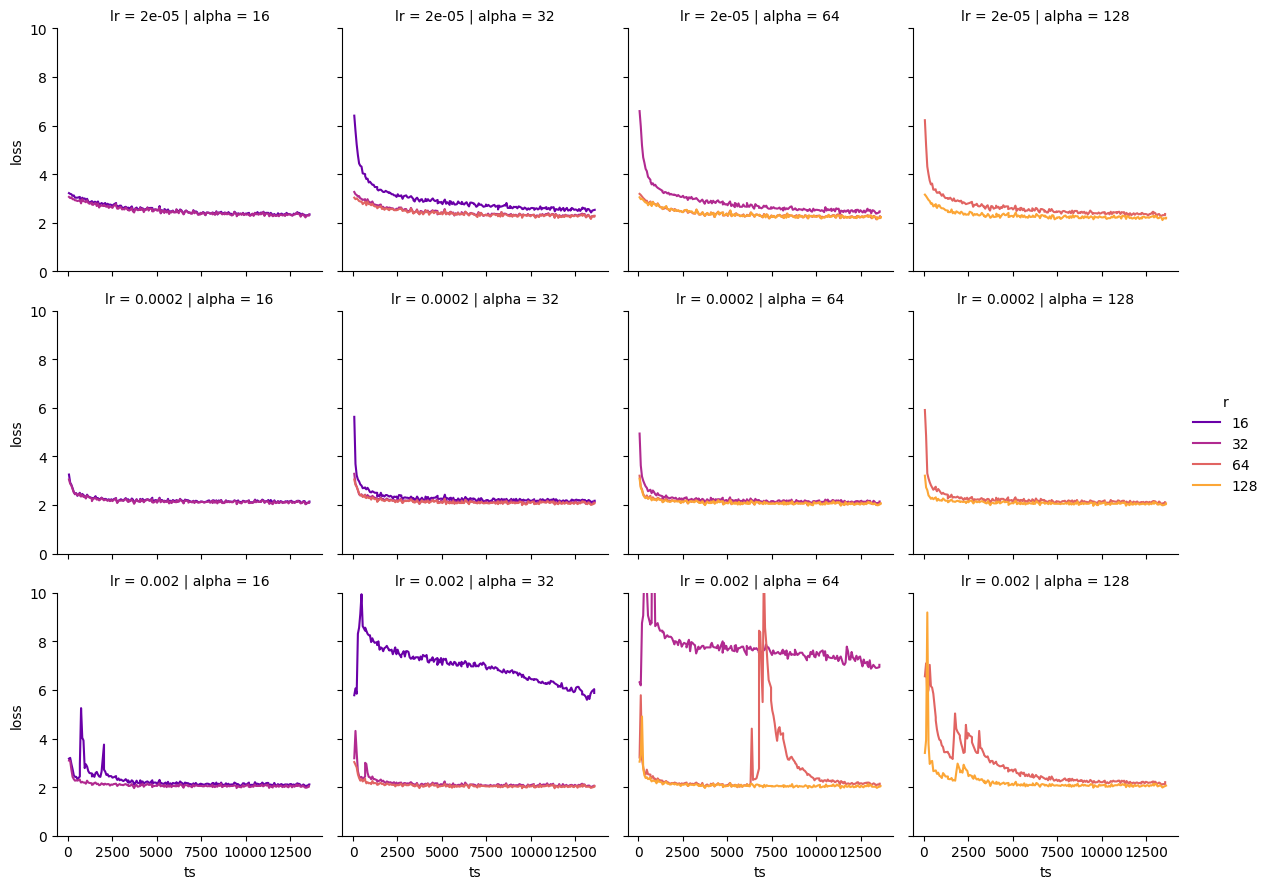

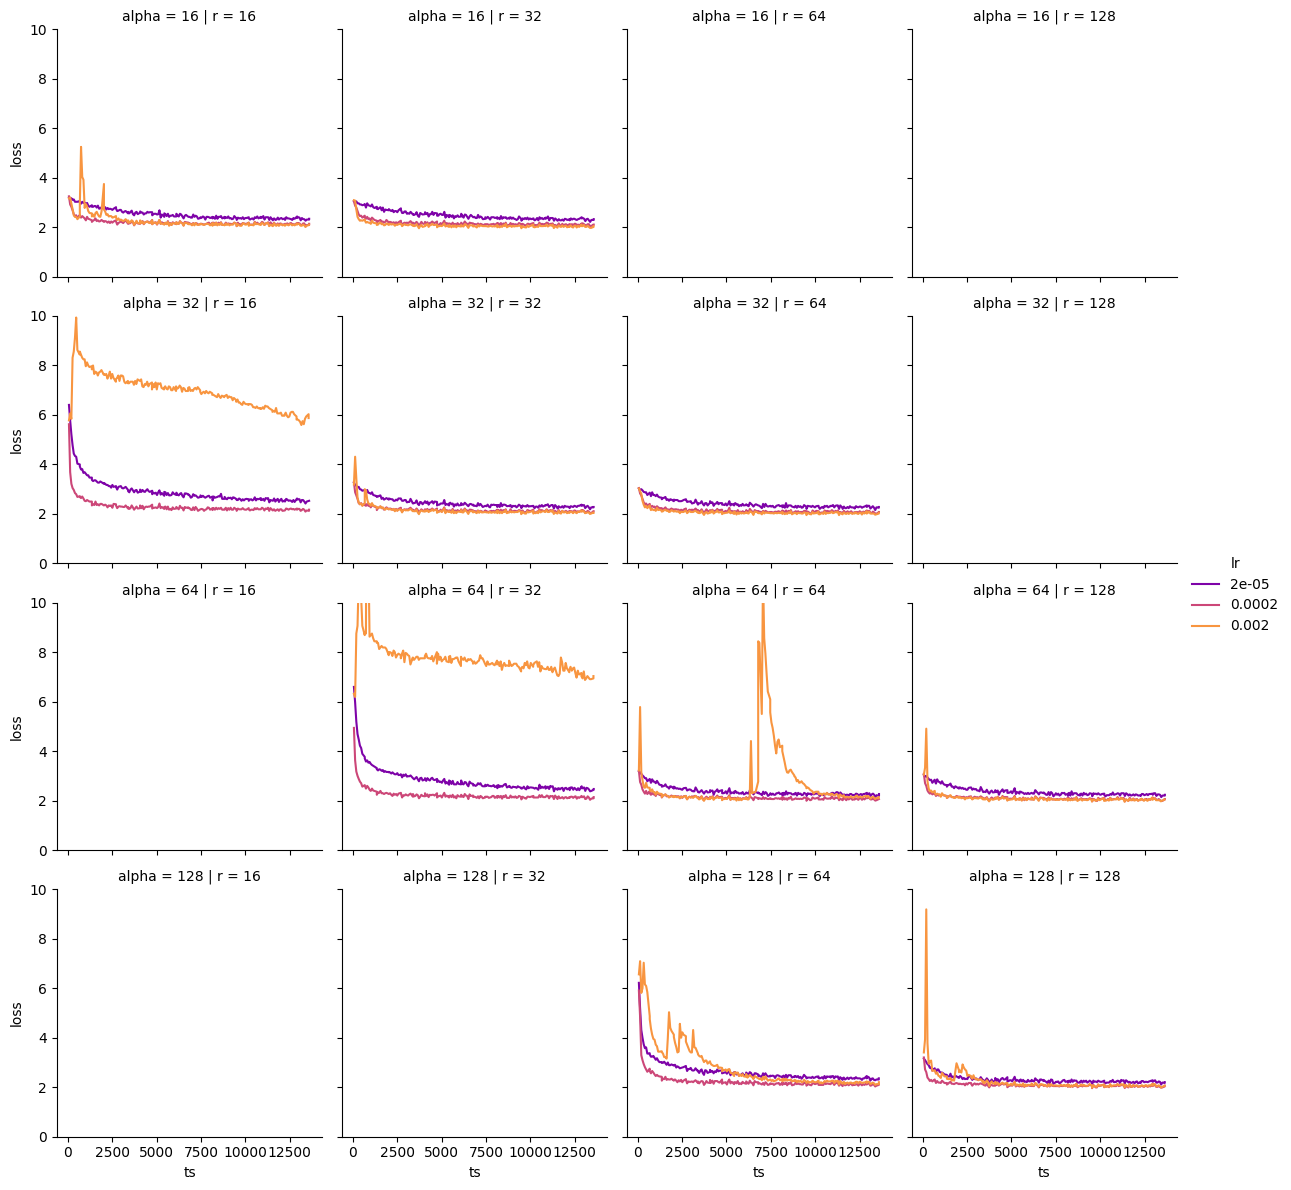

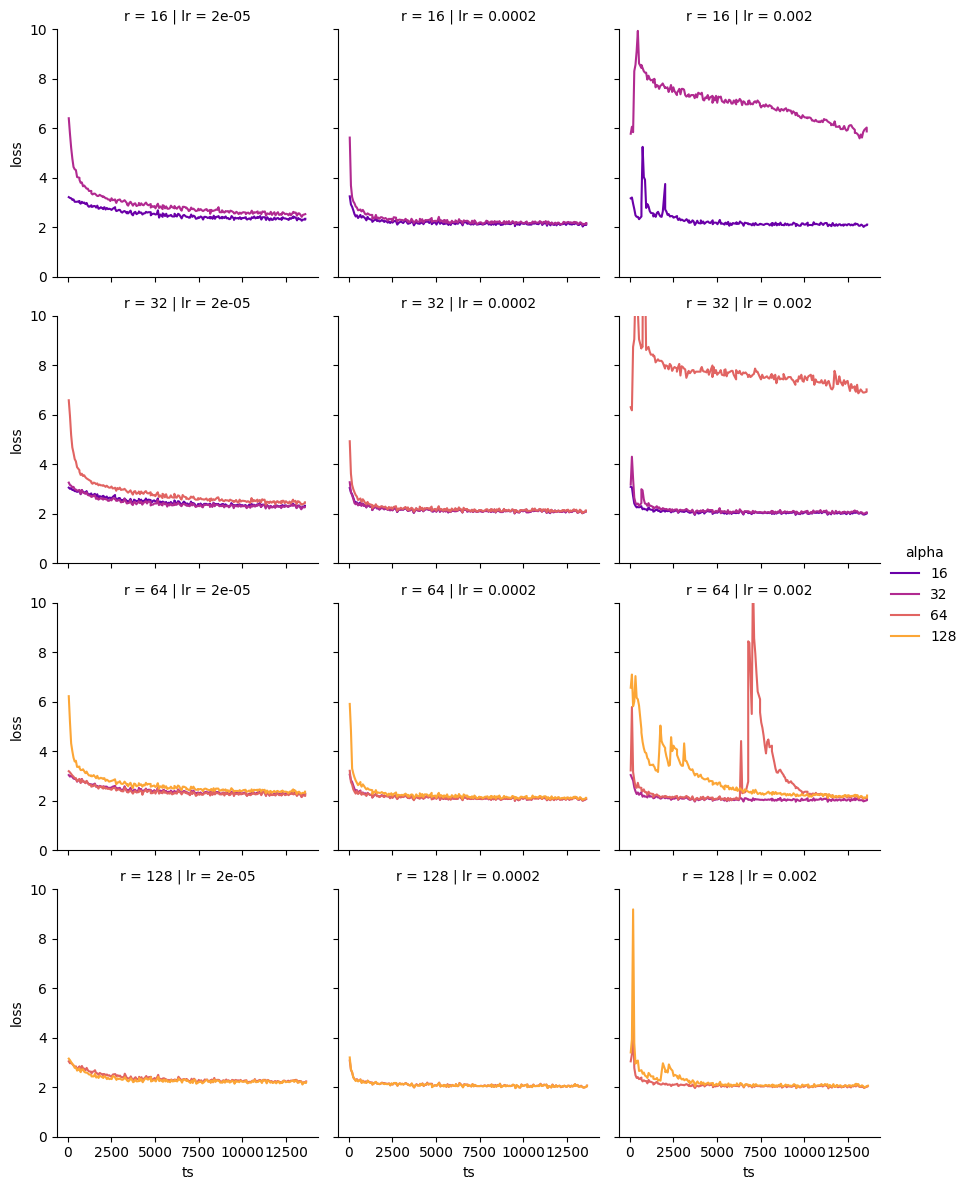

In [46]:
import pandas as pd
import seaborn as sns

permutations = []

for _ in range(len(params_keys)):
    params_keys = params_keys[1:]+params_keys[:1]
    permutations.append(params_keys)
print(permutations)

for per in permutations:
    g = sns.FacetGrid(dataset, row=per[0], col=per[1], hue=per[2], palette="plasma")
    g.map(sns.lineplot, "ts", "loss")
    g.add_legend()
    g.set(ylim=(0, 10))